In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from datetime import date
from datetime import timedelta
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 16, 10

### Label_lines routine - now with tuple_selector option

In [2]:
def label_lines(df, ax, tuple_selector=None, print_value=False):
    '''Labels lines in a chart assuming that some lines will be different lengths than others
       If tuple_selector is set to an integer, use it as an index to the label'''
    for label, series in df.items():
        prev_x = series.index[0]
        prev_data = series.iloc[0]
        for index, data in series.items():
            if pd.isnull(data):
                break
            prev_x = index
            prev_data = data
        if not (tuple_selector is None):
            if print_value:
                label = '{} ({:,})'.format(label[tuple_selector], int(prev_data))
            else:
                label = label[tuple_selector]
        else:
            if print_value:
                label = '{} ({:,})'.format(label, int(prev_data))
        ax.annotate(label, (prev_x, prev_data),
                            xytext=(10,0), 
                            textcoords='offset pixels',
                            family='sans-serif', fontsize=14, color='darkslategrey')

## Read the daily files
### NOTE: The Province/Region field is used inconsistently before 3/22.
###       If you read files before 3/22, only report at the country level.

In [3]:
base_path = 'csse_covid_19_data/csse_covid_19_daily_reports/'

#start = date.fromisoformat('2020-02-29')
start = date.fromisoformat('2020-03-22')  # prior to 3/22 the format is different and province/state has a mix of counties, and states, etc.
end = date.today()

df_all = pd.DataFrame(columns=['FIPS', 'Admin2', 'Province_State', 'Country_Region', 'Last_Update',
                              'Lat', 'Long_', 'Confirmed', 'Deaths', 'Recovered', 'Active', 'Combined_Key'])

def rename_column_if_exists(df, old_col_name, new_col_name):
    if old_col_name in df.columns:
        df.rename(columns = {old_col_name: new_col_name}, inplace=True)
        
def str_join(df, sep, *cols):
    from functools import reduce
    return reduce(lambda x, y: x.astype(str).str.cat(y.astype(str), sep=sep), 
                    [df[col] for col in cols])

def create_combined_key_if_missing(df):
    if not 'Combined_Key' in df.columns:
        df.insert(len(df.columns), 'Combined_Key', np.NaN)
    df_missing = df['Combined_Key'].isna()
    df.loc[df_missing,'Combined_Key'] = df.loc[df_missing,:].Province_State.astype(str).str.cat(df.loc[df_missing,:].Country_Region.astype(str), sep=', ', na_rep='')
    
d = end - start
for dayindex in range(0,d.days+1):
    day = start + timedelta(days=dayindex)
    filename = '{:%m-%d-%Y}'.format(day)
    #print(base_path + filename + '.csv')
    try:
        df_input = pd.read_csv(base_path + filename + '.csv')
    except FileNotFoundError as e:
        print('FileNotFoundError - {}'.format(base_path + filename + '.csv'))
        continue
    rename_column_if_exists(df_input, 'Province/State', 'Province_State')
    rename_column_if_exists(df_input, 'Country/Region', 'Country_Region')
    rename_column_if_exists(df_input, 'Last Update', 'Last_Update')
    rename_column_if_exists(df_input, 'Latitude', 'Lat')
    rename_column_if_exists(df_input, 'Longitude', 'Long_')
    create_combined_key_if_missing(df_input)
    df_all = df_all.append(df_input)
    
df_all['Last_Update'] = pd.to_datetime(df_all.Last_Update) 
df_all['Last_Update'] = pd.to_datetime(df_all['Last_Update'].dt.date)  # the ".dt.date" collapses more granular datetime to just the day (so time-of-day differences aren't on different rows)
    
# Clean it up -- drop unneeded columns and set date as the index
df_clean = df_all.drop(labels=['FIPS', 'Lat', 'Long_'], axis=1)
df_clean = df_clean.melt(id_vars=['Admin2', 'Province_State', 'Country_Region', 'Combined_Key', 'Last_Update'],
            var_name='Metric',
            value_name='Value')
df_clean = df_clean.set_index('Last_Update')

df_clean.loc[(df_clean.Metric=='Deaths') & (df_clean.Country_Region=='US')]

FileNotFoundError - csse_covid_19_data/csse_covid_19_daily_reports/04-21-2020.csv


,Admin2,Province_State,Country_Region,Combined_Key,Metric,Value
Last_Update,,,,,,
2020-03-22,New York City,New York,US,"New York City, New York, US",Deaths,63
2020-03-22,Nassau,New York,US,"Nassau, New York, US",Deaths,4
2020-03-22,Westchester,New York,US,"Westchester, New York, US",Deaths,0
2020-03-22,Suffolk,New York,US,"Suffolk, New York, US",Deaths,9
2020-03-22,Rockland,New York,US,"Rockland, New York, US",Deaths,1
...,...,...,...,...,...,...
2020-04-20,NaN,Guam,US,"Guam, US",Deaths,5
2020-04-20,NaN,Northern Mariana Islands,US,"Northern Mariana Islands, US",Deaths,2
2020-04-20,NaN,Puerto Rico,US,"Puerto Rico, US",Deaths,63


In [4]:
statesdf = (df_clean.loc[df_clean.Country_Region == 'US', ['Province_State', 'Value', 'Metric']]
     .reset_index()     # make the index a column for now
     .pivot_table(index='Last_Update', columns=['Province_State','Metric'], values='Value', aggfunc=np.sum)
     .loc['2020-03-22':,:]
     .dropna(axis=1, how='any')
     .drop(['Northern Mariana Islands', 'Virgin Islands', 'Diamond Princess', 'Grand Princess', 
            'Puerto Rico', 'Guam', 'District of Columbia'], axis=1)
)
statesdf.tail(2)

Province_State Alabama                            Alaska                   \
Metric          Active Confirmed Deaths Recovered Active Confirmed Deaths   
Last_Update                                                                 
2020-04-19      4731.0    4888.0  157.0       0.0  310.0     319.0    9.0   
2020-04-20      4916.0    5079.0  163.0       0.0  312.0     321.0    9.0   

Province_State           Arizona            ... West Virginia            \
Metric         Recovered  Active Confirmed  ...        Deaths Recovered   
Last_Update                                 ...                           
2020-04-19           0.0  4749.0    4933.0  ...          18.0       0.0   
2020-04-20           0.0  4877.0    5068.0  ...          24.0       0.0   

Province_State Wisconsin                            Wyoming                   \
Metric            Active Confirmed Deaths Recovered  Active Confirmed Deaths   
Last_Update                                                                    
2020-04-19        4126.0    4346.0  220.0       0.0   311.0     313.0    2.0   
2020-04-20        4269.0    4499.0  230.0       0.0   315.0     317.0    2.0   

Province_State            
Metric         Recovered  
Last_Update               
2020-04-19           0.0  
2020-04-20           0.0  

[2 rows x 200 columns]

In [5]:
idx = pd.IndexSlice
Any = slice(None)  # could also just use ":", but this is a bit clearer

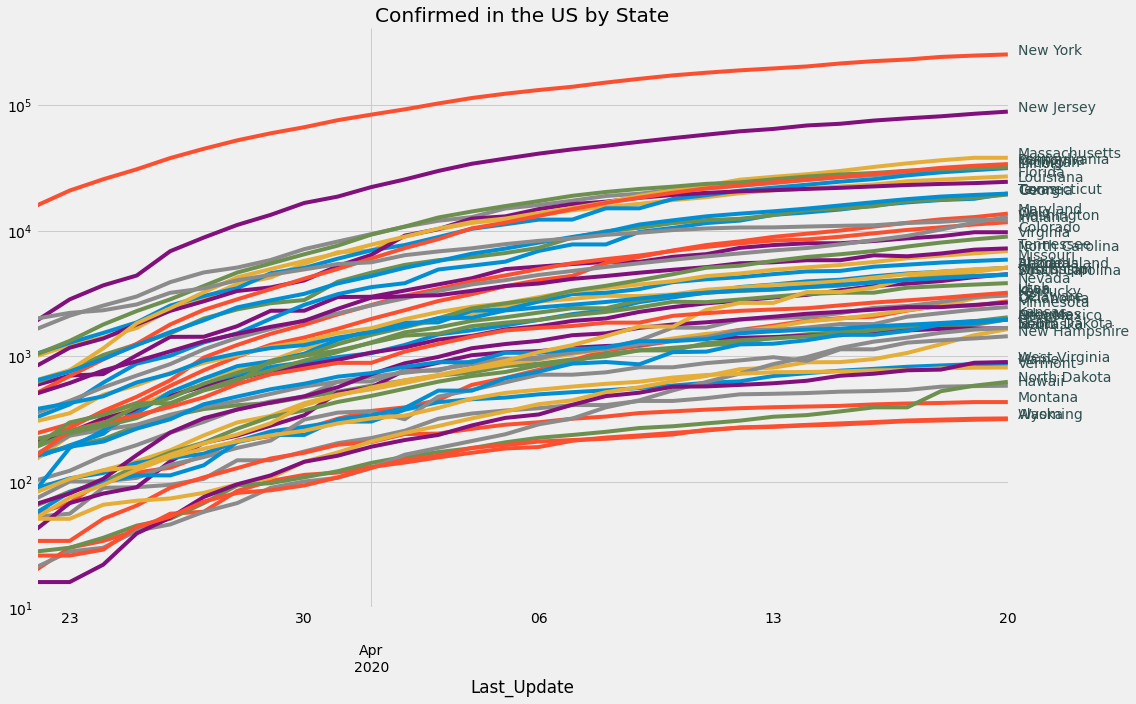

In [6]:
graphdf = statesdf.loc[:,idx[:,'Confirmed']]
ax = graphdf.plot(logy=True, legend=False)
label_lines(graphdf, ax, tuple_selector=0, print_value=False)
plt.title('Confirmed in the US by State')
plt.tight_layout()
sns.despine()
plt.show()


In [7]:
statesdf

Province_State Alabama                            Alaska                   \
Metric          Active Confirmed Deaths Recovered Active Confirmed Deaths   
Last_Update                                                                 
2020-03-22         0.0     157.0    0.0       0.0    0.0      20.0    0.0   
2020-03-23         0.0     196.0    0.0       0.0    0.0      30.0    0.0   
2020-03-24         0.0     242.0    0.0       0.0    0.0      34.0    0.0   
2020-03-25         0.0     381.0    1.0       0.0    0.0      41.0    1.0   
2020-03-26         0.0     517.0    1.0       0.0    0.0      56.0    1.0   
2020-03-27         0.0     587.0    4.0       0.0    0.0      58.0    1.0   
2020-03-28         0.0     694.0    4.0       0.0    0.0      85.0    2.0   
2020-03-29         0.0     825.0   10.0       0.0    0.0     102.0    2.0   
2020-03-30         0.0     899.0   10.0       0.0    0.0     114.0    3.0   
2020-03-31         0.0     987.0   23.0       0.0    0.0     119.0    3.0   
2020-04-01         0.0    1060.0   27.0       0.0    0.0     132.0    3.0   
2020-04-02         0.0    1233.0   32.0       0.0    0.0     143.0    3.0   
2020-04-03         0.0    1495.0   38.0       0.0    0.0     157.0    3.0   
2020-04-04         0.0    1614.0   44.0       0.0    0.0     171.0    5.0   
2020-04-05         0.0    1765.0   45.0       0.0    0.0     185.0    6.0   
2020-04-06         0.0    1952.0   49.0       0.0    0.0     190.0    6.0   
2020-04-07         0.0    2169.0   64.0       0.0    0.0     213.0    6.0   
2020-04-08         0.0    2328.0   66.0       0.0    0.0     226.0    7.0   
2020-04-09         0.0    2703.0   70.0       0.0    0.0     235.0    7.0   
2020-04-10         0.0    2947.0   80.0       0.0    0.0     246.0    7.0   
2020-04-11         0.0    3217.0   92.0       0.0    0.0     257.0    8.0   
2020-04-12      3470.0    3563.0   93.0       0.0  264.0     272.0    8.0   
2020-04-13      3635.0    3734.0   99.0       0.0  269.0     277.0    8.0   
2020-04-14      3839.0    3953.0  114.0       0.0  276.0     285.0    9.0   
2020-04-15      3957.0    4075.0  118.0       0.0  284.0     293.0    9.0   
2020-04-16      4212.0    4345.0  133.0       0.0  291.0     300.0    9.0   
2020-04-17      4423.0    4571.0  148.0       0.0  300.0     309.0    9.0   
2020-04-18      4559.0    4712.0  153.0       0.0  305.0     314.0    9.0   
2020-04-19      4731.0    4888.0  157.0       0.0  310.0     319.0    9.0   
2020-04-20      4916.0    5079.0  163.0       0.0  312.0     321.0    9.0   

Province_State           Arizona            ... West Virginia            \
Metric         Recovered  Active Confirmed  ...        Deaths Recovered   
Last_Update                                 ...                           
2020-03-22           0.0     0.0     152.0  ...           0.0       0.0   
2020-03-23           0.0     0.0     235.0  ...           0.0       0.0   
2020-03-24           0.0     0.0     326.0  ...           0.0       0.0   
2020-03-25           0.0     0.0     401.0  ...           0.0       0.0   
2020-03-26           0.0     0.0     508.0  ...           0.0       0.0   
2020-03-27           0.0     0.0     665.0  ...           0.0       0.0   
2020-03-28           0.0     0.0     773.0  ...           0.0       0.0   
2020-03-29           0.0     0.0     919.0  ...           0.0       0.0   
2020-03-30           0.0     0.0    1157.0  ...           1.0       0.0   
2020-03-31           0.0     0.0    1289.0  ...           1.0       0.0   
2020-04-01           0.0     0.0    1530.0  ...           1.0       0.0   
2020-04-02           0.0     0.0    1715.0  ...           2.0       0.0   
2020-04-03           0.0     0.0    1937.0  ...           2.0       0.0   
2020-04-04           0.0     0.0    2187.0  ...           2.0       0.0   
2020-04-05           0.0     0.0    2486.0  ...           3.0       0.0   
2020-04-06           0.0     0.0    2732.0  ...           4.0       0.0   
2020-04-07           0.0     0.0 

## Calculate doubling time

In [8]:
temp = (statesdf.loc[:,idx[:,'Confirmed']]
     .stack(0)
     .unstack(0)
)
temp.tail(2)

Metric          Confirmed                                              \
Last_Update    2020-03-22 2020-03-23 2020-03-24 2020-03-25 2020-03-26   
Province_State                                                          
Wisconsin           381.0      425.0      481.0      621.0      728.0   
Wyoming              26.0       26.0       29.0       44.0       53.0   

Metric                                                                 ...  \
Last_Update    2020-03-27 2020-03-28 2020-03-29 2020-03-30 2020-03-31  ...   
Province_State                                                         ...   
Wisconsin           926.0     1055.0     1164.0     1230.0     1412.0  ...   
Wyoming              70.0       82.0       86.0       94.0      109.0  ...   

Metric                                                                 \
Last_Update    2020-04-11 2020-04-12 2020-04-13 2020-04-14 2020-04-15   
Province_State                                                          
Wisconsin          3213.0     3341.0     3428.0     3555.0     3721.0   
Wyoming             261.0      270.0      275.0      282.0      287.0   

Metric                                                                 
Last_Update    2020-04-16 2020-04-17 2020-04-18 2020-04-19 2020-04-20  
Province_State                                                         
Wisconsin          3875.0     4053.0     4199.0     4346.0     4499.0  
Wyoming             296.0      305.0      309.0      313.0      317.0  

[2 rows x 30 columns]

In [9]:
start_day = '2020-03-22'
end_day = (date.today() - timedelta(days=1)).isoformat()
end_day_20200404 = '2020-04-04'
print(end_day)
num_days = (date.fromisoformat(end_day) - date.fromisoformat(start_day)).days
num_days_20200404 = (date.fromisoformat(end_day_20200404) - date.fromisoformat(start_day)).days
print(num_days)

# Calculate for the most recent end day first
end_values = temp.loc[:,idx[:,end_day]].stack().stack().reset_index().iloc[:,3] # the end gets rid of index
start_values = temp.loc[:,idx[:,start_day]].stack().stack().reset_index().iloc[:,3]
df_doubling = pd.DataFrame(index=temp.index,
                          data = (num_days * (np.log(2)/np.log(end_values/start_values))).values
                          )
df_doubling = df_doubling.rename(columns={0:'Doubling_days'})

# Calculate for 2020-04-04 which is the first time I did this chart, to compare
end_values_20200404 = temp.loc[:,idx[:,end_day_20200404]].stack().stack().reset_index().iloc[:,3] # the end gets rid of index
df_doubling_20200404 = pd.DataFrame(index=temp.index,
                          data = (num_days_20200404 * (np.log(2)/np.log(end_values/start_values))).values
                          )
df_doubling_20200404 = df_doubling_20200404.rename(columns={0:'Doubling_days'})



2020-04-20
29


## Read population and mobility study files

In [10]:
df_population = pd.read_csv('US_State_Populations.csv')
df_population.tail(2)

,rank,State,Pop,Growth,Pop2018,Pop2010,growthSince2010,Percent,density
50,51,Vermont,628061,0.0028,626299,625880,0.0035,0.0019,68.1416
51,52,Wyoming,567025,-0.0185,577737,564483,0.0045,0.0017,5.8400


In [11]:
df_mobility = pd.read_csv('US Mobility Report 2020-03-29 - Sheet1.csv',
                         dtype= {'Retail_recreation': np.float64,
                                 'Grocery_pharmacy': np.float64,
                                 'Parks': np.float64,
                                 'Transit_stations': np.float64,
                                 'Workplaces': np.float64,
                                 'Residential': np.float64,
                                }
                         )
df_mobility = df_mobility.rename(columns = {'Residential': 'Residence'},)
                                 
df_mobility.tail(2)

,Location,Retail_recreation,Grocery_pharmacy,Parks,Transit_stations,Workplaces,Residence,2016_candidate,governor_party
50,Wisconsin,-0.55,-0.30,-0.12,-0.50,-0.34,0.13,Trump,Democratic
51,Wyoming,-0.37,-0.13,0.29,-0.14,-0.29,0.08,Trump,Republican


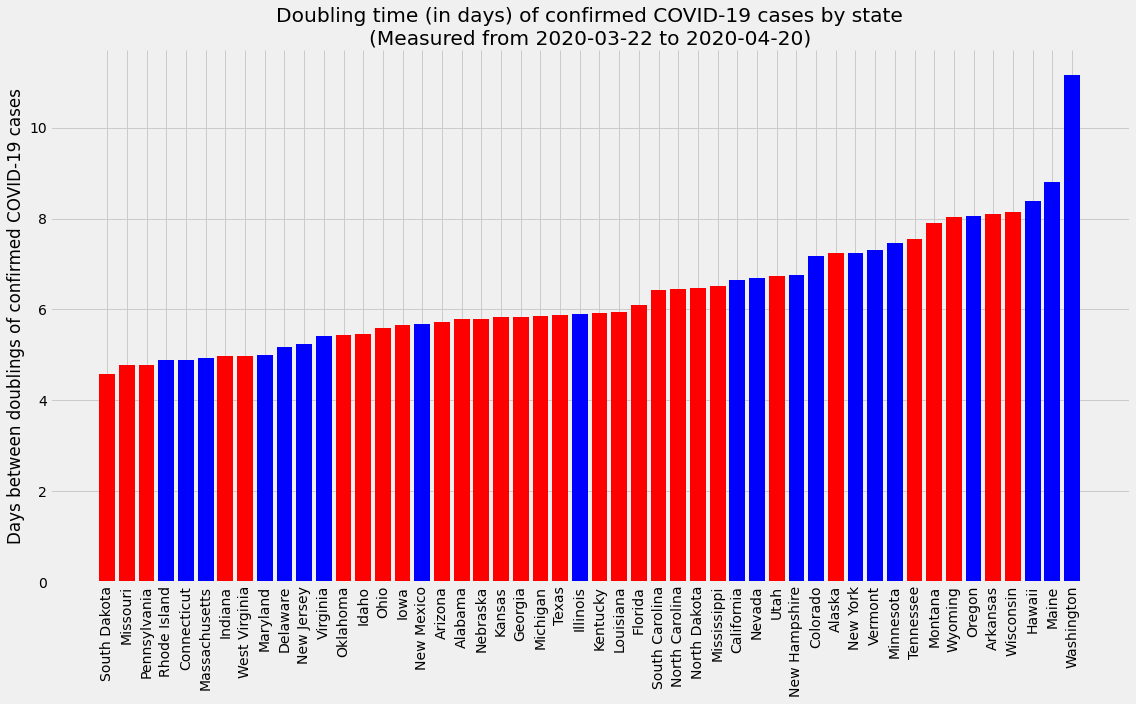

In [12]:
graphdf = df_doubling.sort_values(by='Doubling_days')
def doubling_graph(graphdf, df_mobility, start_day=start_day, end_day=end_day, use_governor=False):
    graphdf['2016_candidate'] = df_mobility.set_index('Location')['2016_candidate']
    graphdf['governor_party'] = df_mobility.set_index('Location')['governor_party']
    ax = plt.gca()
    pos = np.arange(len(graphdf.index))
    if use_governor:
        colors = ['red' if gov=='Republican' else 'blue' for gov in graphdf['governor_party']]
    else:
        colors = ['red' if candidate=='Trump' else 'blue' for candidate in graphdf['2016_candidate']]
    plt.bar(pos, graphdf.loc[:,'Doubling_days'], color=colors)
    plt.xticks(pos, graphdf.index, rotation='vertical')
    plt.title('Doubling time (in days) of confirmed COVID-19 cases by state\n(Measured from {} to {})'.format(start_day, end_day))
    plt.ylabel('Days between doublings of confirmed COVID-19 cases'.format(start_day, end_day))
    #plt.legend(bbox_to_anchor=(1, 1))
    plt.tight_layout()
    sns.despine()
    plt.show()
    return ax
ax = doubling_graph(graphdf, df_mobility, use_governor=False)
fig = ax.get_figure()
fig.savefig('doubling.png')


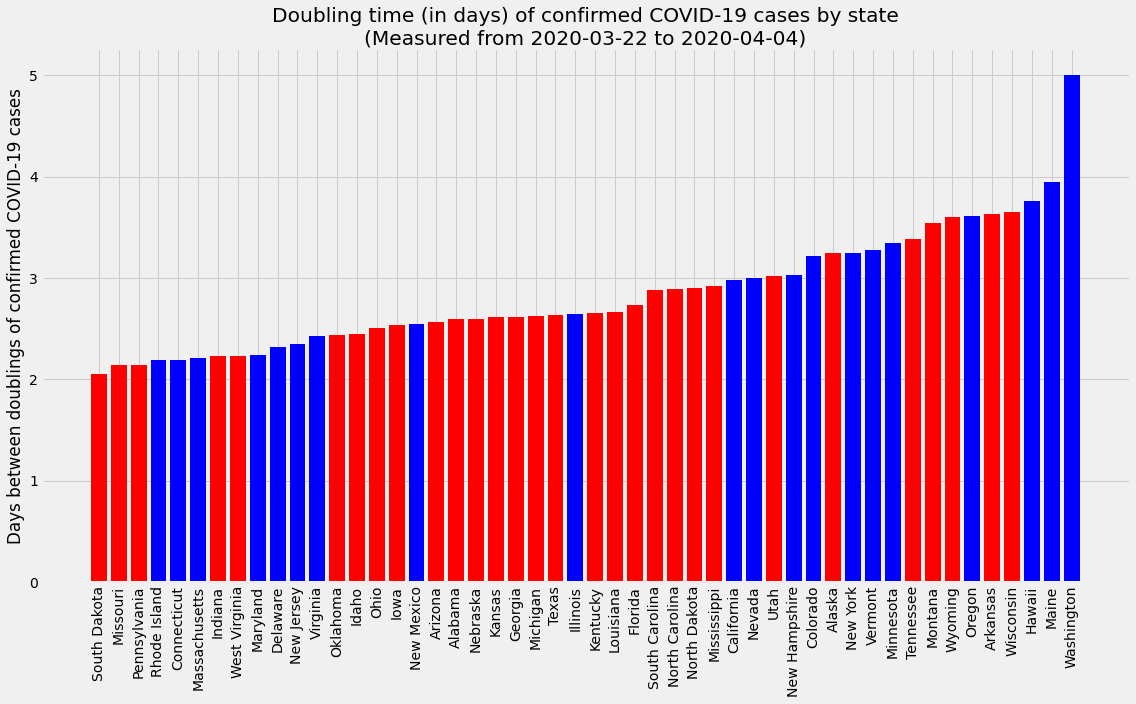

In [13]:
doubling_graph(df_doubling_20200404.sort_values(by='Doubling_days'), df_mobility, end_day = '2020-04-04', use_governor=False)

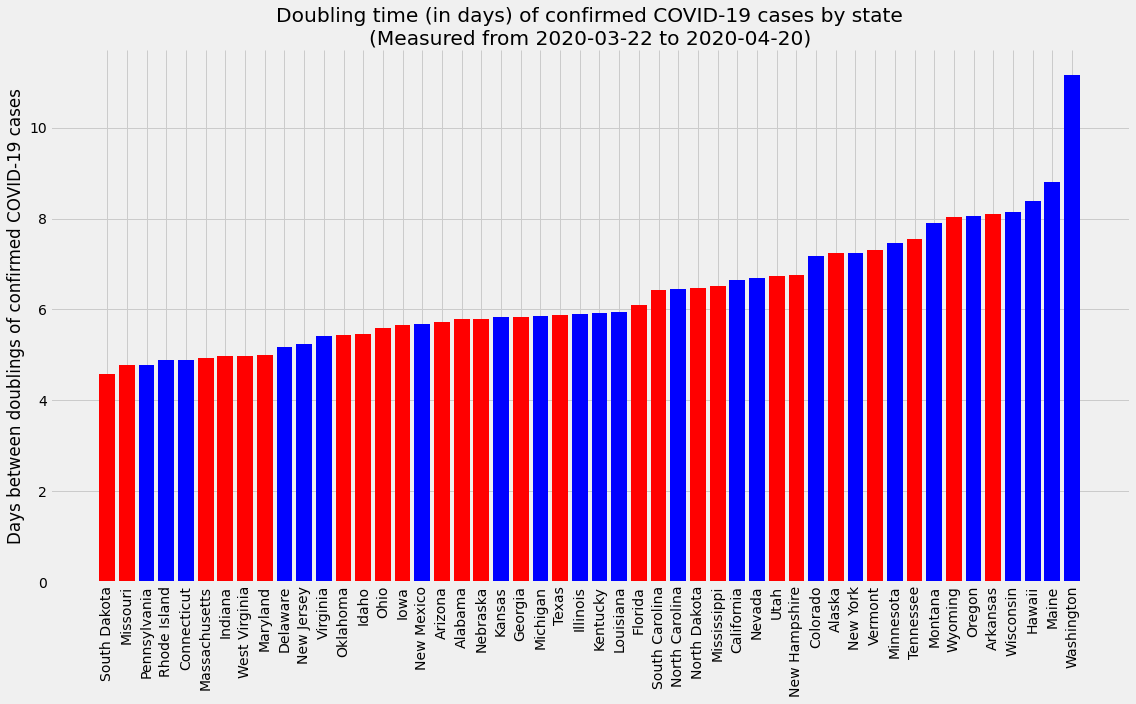

In [14]:
doubling_graph(graphdf, df_mobility, use_governor=True)

In [15]:

def graph_change(metric, color_red_blue=False):
    graphdf = (df_mobility.loc[df_mobility.Location!='USA',:]
                  .set_index('Location')
                  .drop('District of Columbia', axis=0)
                  .sort_values(by=metric)
              )
    import matplotlib.ticker as mtick
    ax = plt.gca()
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    pos = np.arange(len(graphdf.index))
    if color_red_blue:
        colors = ['red' if candidate=='Trump' else 'blue' for candidate in graphdf['2016_candidate']]
        plt.bar(pos, graphdf[metric]*100, color=colors)
    else:
        plt.bar(pos, graphdf[metric]*100)
    plt.xticks(pos, graphdf.index, rotation='vertical')
    plt.title('Change in time spent at {} by state'.format(metric))
    plt.ylabel('Change in time spent at {}'.format(metric))
    plt.tight_layout()
    sns.despine()
    plt.show()
    fig = ax.get_figure()
    fig.savefig('{}.png'.format(metric))

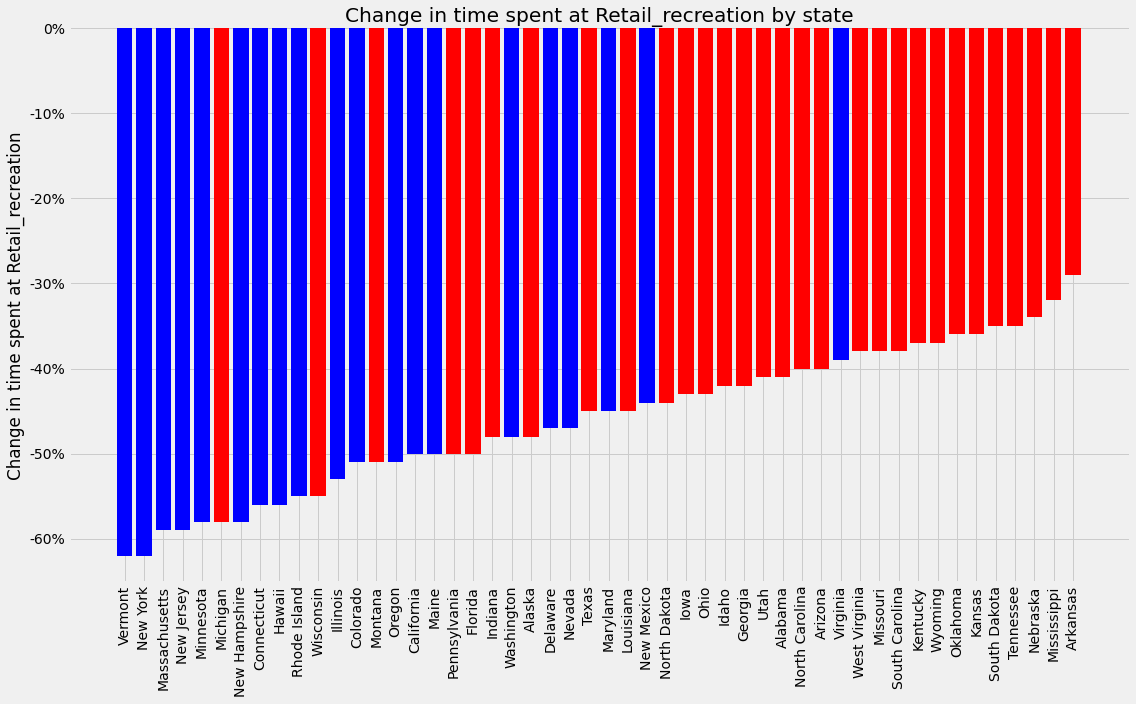

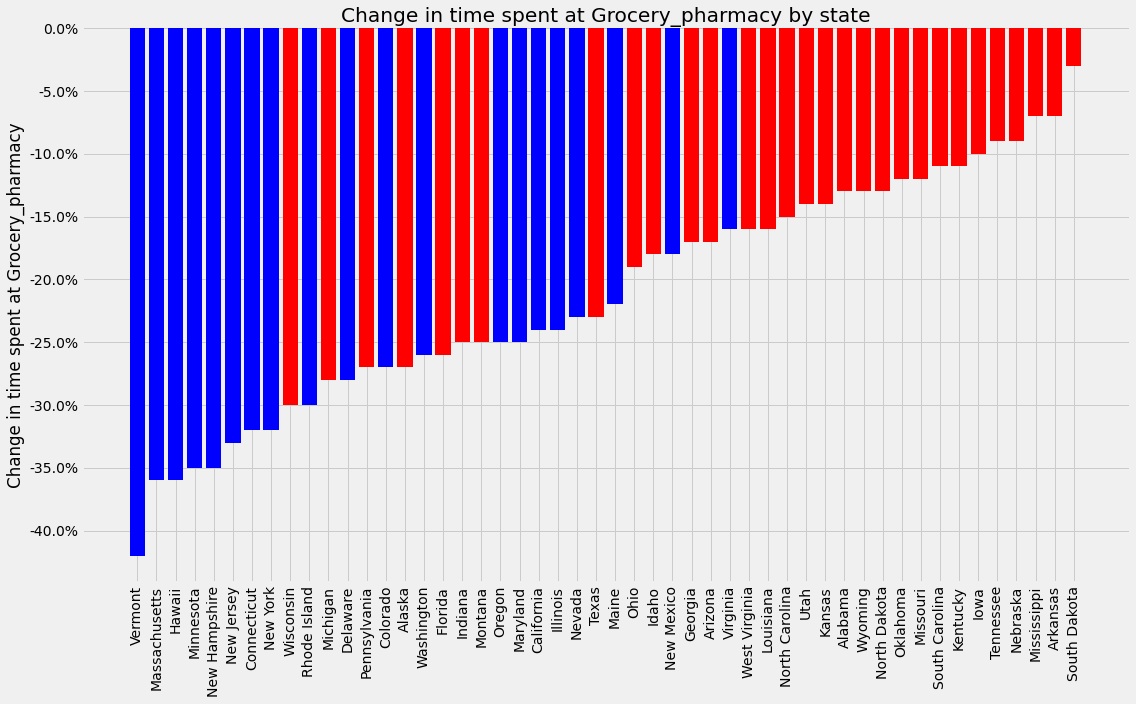

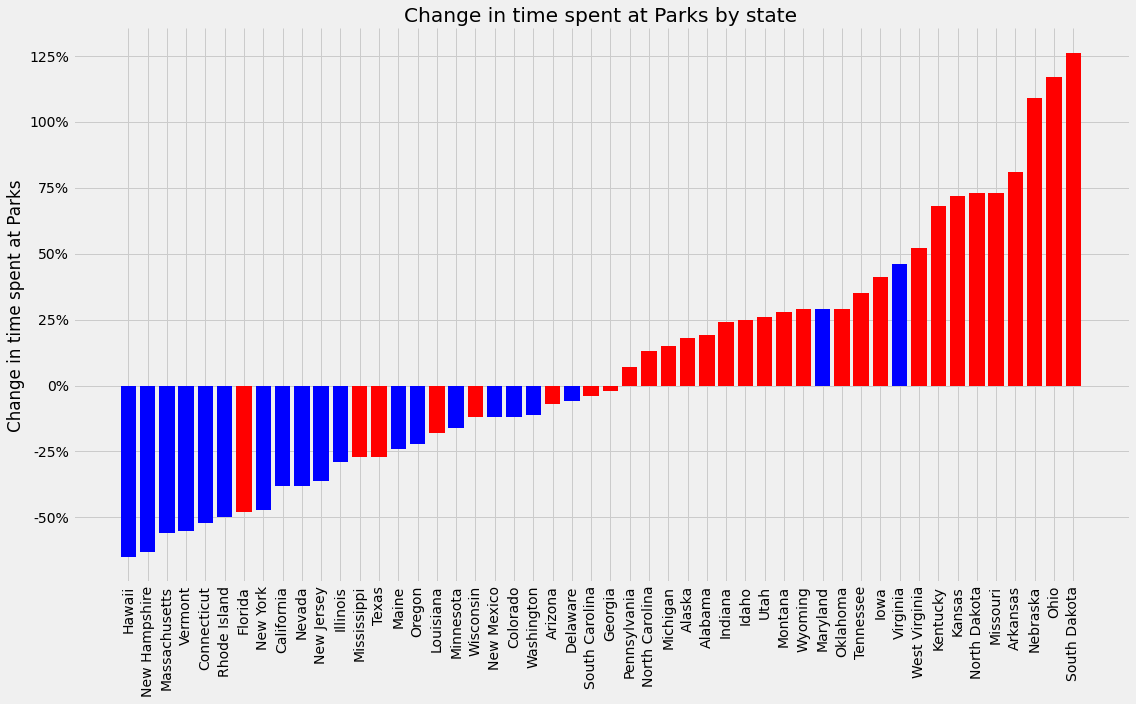

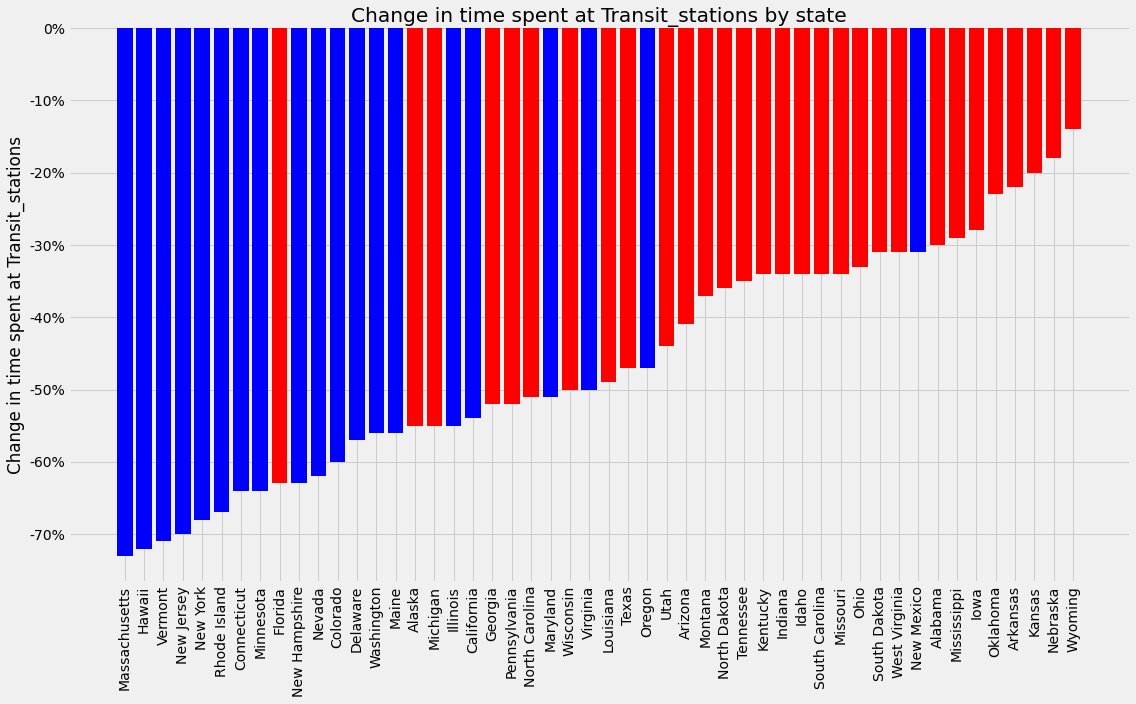

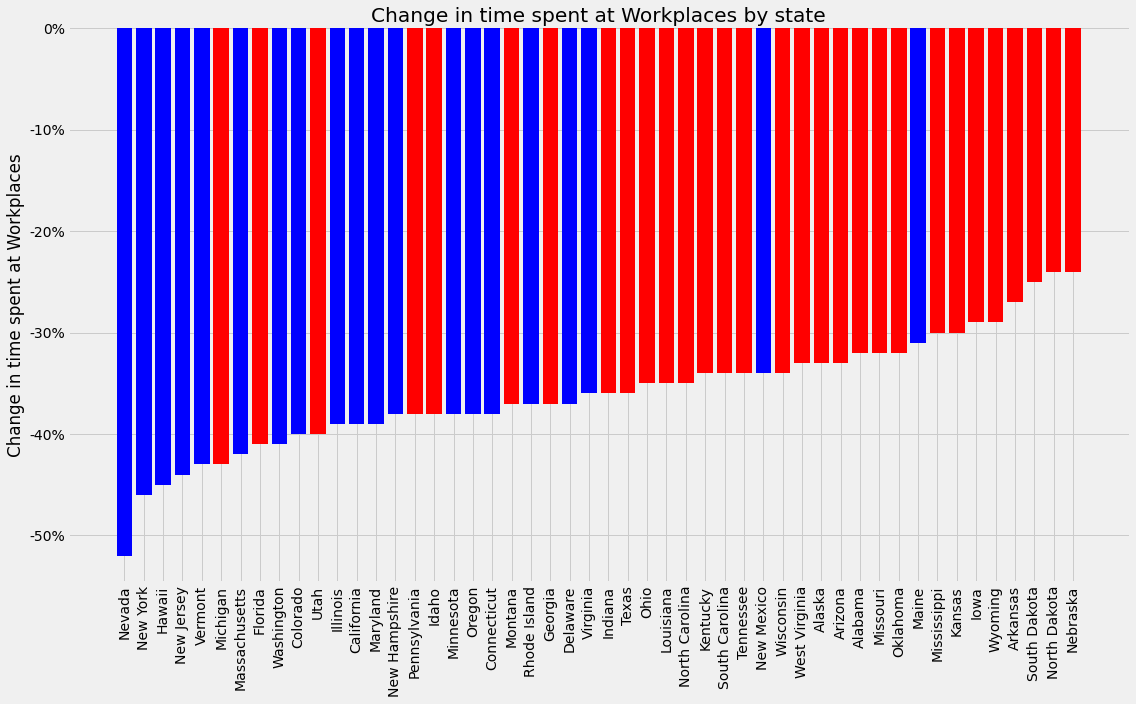

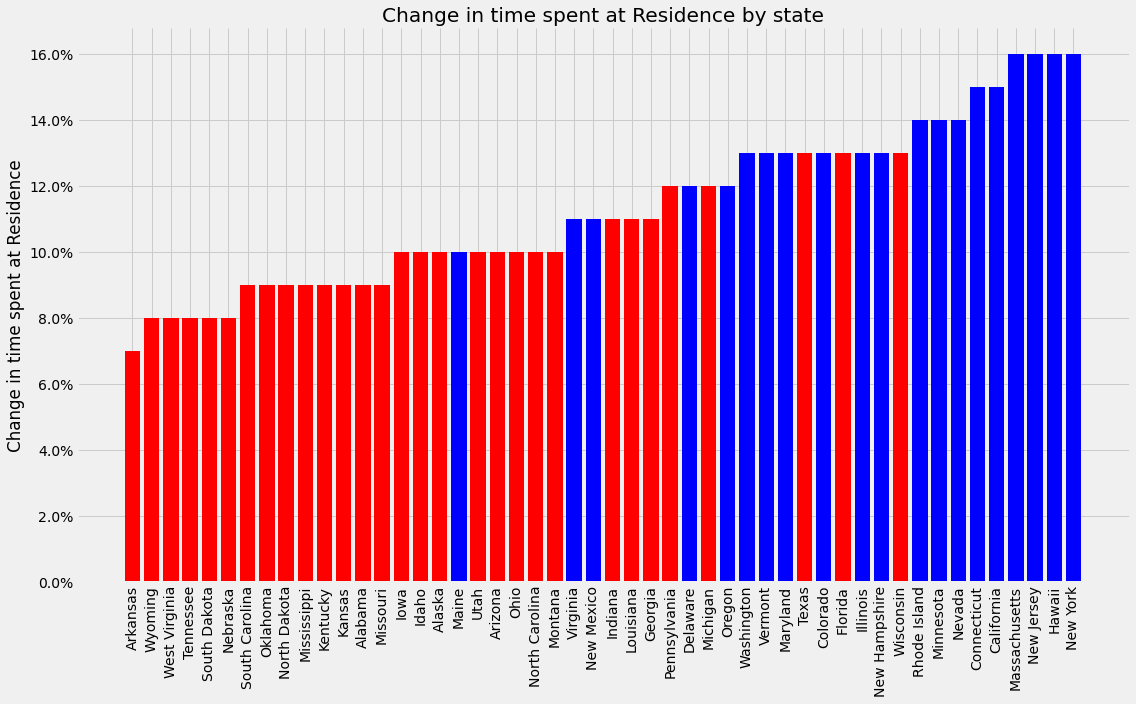

In [16]:
for metric in ['Retail_recreation','Grocery_pharmacy',
              'Parks', 'Transit_stations',
              'Workplaces', 'Residence']:
    graph_change(metric, color_red_blue=True)

In [17]:
mobility_location = 'Residence'
df_doubling_residence = df_doubling.sort_values(by=df_doubling.columns[0])
df_doubling_residence['Red_blue'] = df_mobility.set_index('Location')['2016_candidate']
df_doubling_residence.Red_blue = df_doubling_residence.Red_blue.astype('category')
print(df_doubling_residence.Red_blue.cat.categories)
df_doubling_residence.Red_blue.cat.categories = ['b', 'r']
df_doubling_residence[mobility_location] = df_mobility.set_index('Location')[mobility_location]
df_doubling_residence.tail(2)

Index(['Clinton', 'Trump'], dtype='object')


,Doubling_days,Red_blue,Residence
Province_State,,,
Maine,8.794793,b,0.10
Washington,11.150548,b,0.13


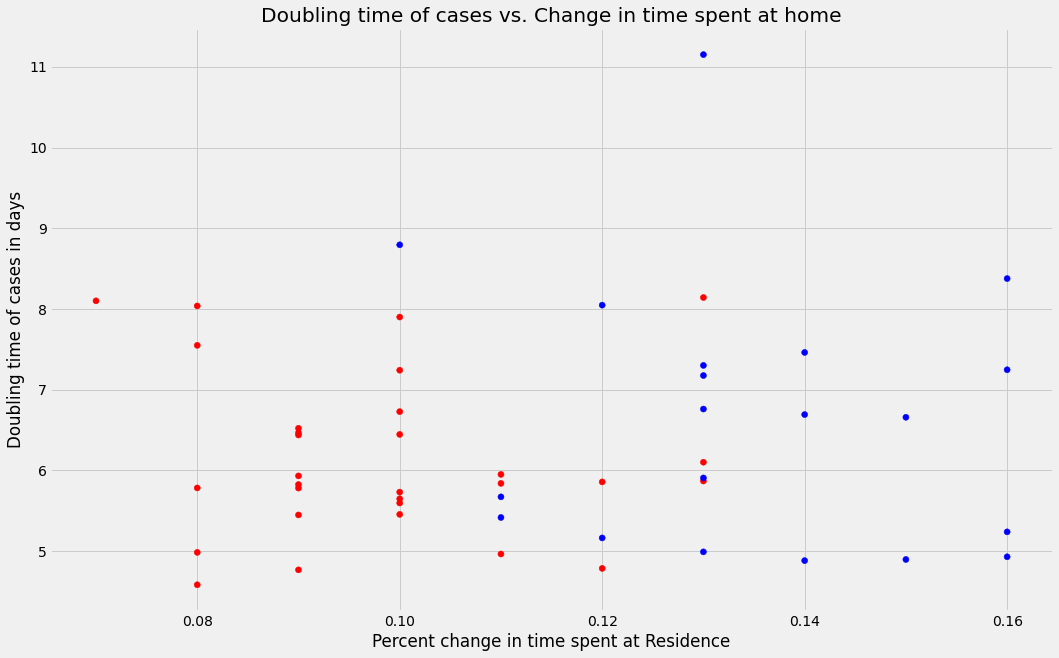

In [18]:
a = df_doubling_residence[mobility_location]
b = df_doubling_residence['Doubling_days']

ax = plt.gca()
pos = np.arange(len(df_doubling_residence.index))
colors = ['red' if rb=='r' else 'blue' for rb in df_doubling_residence.Red_blue]
plt.scatter(a, b, color=colors)
#plt.tight_layout()
plt.title('Doubling time of cases vs. Change in time spent at home')
plt.ylabel("Doubling time of cases in days")
plt.xlabel("Percent change in time spent at Residence")
#sns.despine()
plt.show()
fig = ax.get_figure()
fig.savefig('scatter_doubling_residence.png')

In [19]:
df_doubling_residence.groupby(['Red_blue']).mean()

,Doubling_days,Residence
Red_blue,,
b,6.638745,0.135000
r,6.149857,0.098333


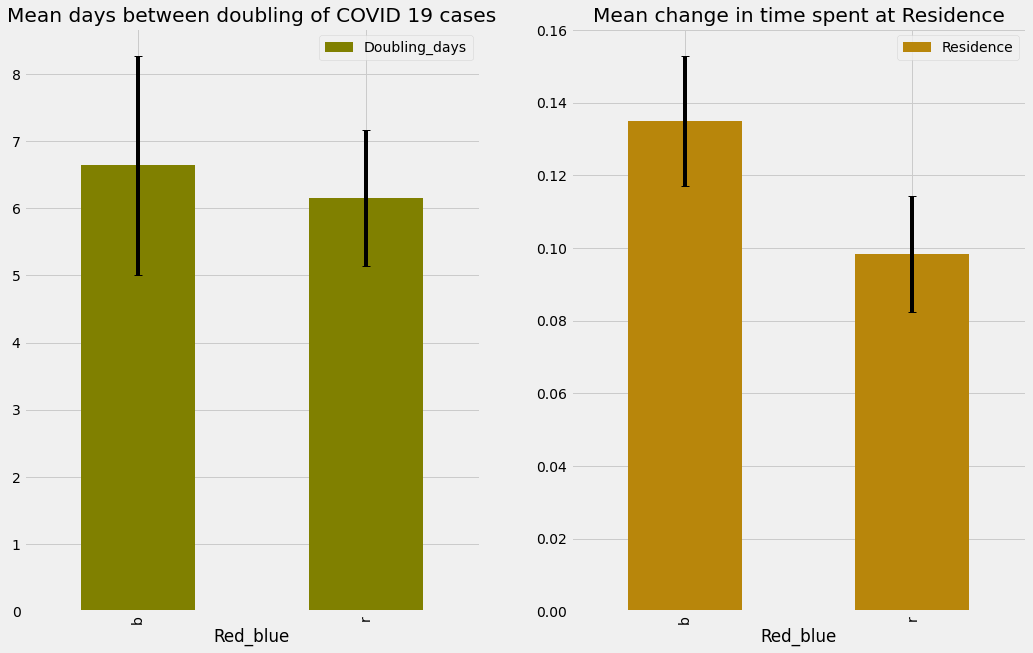

In [20]:
gb = df_doubling_residence.loc[:,['Red_blue','Doubling_days']].groupby(['Red_blue'])
means = gb.mean()
errors = gb.std()
fig, ax = plt.subplots(nrows=1, ncols=2)
means.plot.bar(yerr=errors, ax=ax[0], capsize=4, color=['olive'])
ax[0].set_title('Mean days between doubling of COVID 19 cases')

gb = df_doubling_residence.loc[:,['Red_blue','Residence']].groupby(['Red_blue'])
means = gb.mean()
errors = gb.std()
means.plot.bar(yerr=errors, ax=ax[1], capsize=4, color='darkgoldenrod')
ax[1].set_title('Mean change in time spent at Residence')

fig.savefig('error_bars_doubling_residence.png')


In [21]:
a = df_doubling_residence.loc[df_doubling_residence.Red_blue=='r','Doubling_days'] 
b = df_doubling_residence.loc[df_doubling_residence.Red_blue=='b','Doubling_days']
print('mean doubling days for red states is {}, for blue states is {}'.format(np.mean(a), np.mean(b)))

mean doubling days for red states is 6.149857235324168, for blue states is 6.638744536547181


In [22]:
# Method #1 from scipy
tstat, p = scipy.stats.ttest_ind(a=a, 
                                 b=b, 
                                 equal_var=True)
print('tstat={}, p={}'.format(tstat, p))

tstat=-1.3090733993358086, p=0.19674196063412525


with a p value of 0.13, we **accept** the null hypothesis that the means are **not** different

In [23]:
a = df_doubling_residence.loc[df_doubling_residence.Red_blue=='r','Residence'] 
b = df_doubling_residence.loc[df_doubling_residence.Red_blue=='b','Residence']
print('mean change in time spent in Residence for red states is {}, for blue states is {}'.format(np.mean(a), np.mean(b)))

mean change in time spent in Residence for red states is 0.09833333333333333, for blue states is 0.135


In [24]:
# Method #1 from scipy
tstat, p = scipy.stats.ttest_ind(a=a, 
                                 b=b, 
                                 equal_var=True)
print('tstat={}, p={}'.format(tstat, p))

tstat=-7.56916321746183, p=9.919261747320395e-10


with a p value of 0.00000000099, we **reject** the null hypothesis that the means are **not** different.  The values **are** different